<a href="https://colab.research.google.com/github/JGH94/Colab_ML_CRAFT/blob/branch/Colab_ML_CRAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-ocr

     |████████████████████████████████| 41 kB 197 kB/s 
     |████████████████████████████████| 9.5 MB 6.1 MB/s 
     |████████████████████████████████| 123 kB 47.9 MB/s 
     |████████████████████████████████| 869 kB 31.3 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir ='.'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf
import keras_ocr

In [5]:
import glob
data_dir ='/content/license_plate_detection_data.zip' 

In [7]:
!unzip license_plate_detection_data.zip

Archive:  license_plate_detection_data.zip
   creating: license_plate_detection_data/
   creating: license_plate_detection_data/images/
  inflating: license_plate_detection_data/images/wts-lg-000087.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000088.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000089.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000090.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000091.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000094.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000095.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000096.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000097.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000098.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000099.jpg  
  inflating: license_plate_detection_data/images/wts-lg-000100.jpg  
  inflating: license_plate_detection

In [35]:
def get_licenseplate_detector_Dataset(cache_dir= None):
  if cache_dir == None: 
    raise ValueError('Cache_dir is None')
  Main_Dir = os.path.join(cache_dir,'/content/license_plate_detection_data')
  Training_Image_Dir = os.path.join(Main_Dir, 'images')
  Training_gt_Dir = os.path.join(Main_Dir,'annotations')
  Dataset = []
  for file_path in glob.glob(os.path.join(Training_gt_Dir,'*txt')):
    Image_Id = os.path.split(file_path)[1].split('.')[0]
    Image_path = os.path.join(Training_Image_Dir, Image_Id +'.jpg')
    lines = []
    with open(file_path, 'r') as f:
      for row in f.read().split('\n'):
        current_line =[]
        row = row.split(' ')
        character = row[-1][1:-1]
        x1,y1, x2,y1, x2,y2, x1,y2 = map(int, row[:8])
        current_line.append((np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]]), character))
        lines.append(current_line)
    lines = [ line for line in lines if line]
    Dataset.append((Image_path, lines, 1))
  return Dataset

In [36]:
Dataset = get_licenseplate_detector_Dataset(cache_dir='')

In [37]:
train, validation = sklearn.model_selection.train_test_split(
    Dataset, train_size = 0.8, random_state =42
)
Augmenter = imgaug.augmenters.Sequential([ 
     imgaug.augmenters.Affine(
         scale=(1.0,1.2),
        rotate=(-5,5)
     ),
    imgaug.augmenters.GaussianBlur(sigma=(0,0.5)),
    imgaug.augmenters.Multiply((0.8,1.2), per_channel=0.2)
])
Generator_kwargs={'width':650,'height':640}
Training_Image_Generator = keras_ocr.datasets.get_detector_image_generator(
    labels = train,
    augmenter = Augmenter,
    **Generator_kwargs
)  
Validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels = validation,
    **Generator_kwargs
)

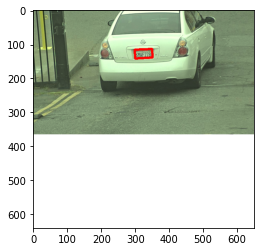

In [38]:
image, lines, confidence = next(Training_Image_Generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes= lines, boxes_format= 'lines')
plt.imshow(canvas)

In [39]:
#학습하면서 중간에 저장
data_dir ='/content'
Detector = keras_ocr.detection.Detector()
#Restore Model weights
Loading_Model = os.path.join(data_dir,'detector_carplate.h5')
if os.path.isfile(Loading_Model)==True:
  Detector.model.load_weights(Loading_Model)
  print(Loading_Model+' Load SC!!')


Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [ ]:
Batch_Size = 1
training_generator, validation_generator = [
    Detector.get_batch_generator(
        image_generator = image_generator, batch_size = Batch_Size)
      for image_generator in
      [Training_Image_Generator, Validation_image_generator] 
]
Detector.model.fit_generator(
    generator = training_generator,
    steps_per_epoch = math.ceil(len(train)/ Batch_Size),
    epochs = 100,
    workers = 0,
    callbacks =[
                tf.keras.callbacks.CSVLogger(os.path.join(data_dir,'detector_carplate.csv'), append= True),
                tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_carplate.h5'))
    ],
    validation_data = validation_generator,
    validation_steps = math.ceil(len(validation)/Batch_Size)

)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
177/177 [==============================] - 177s 791ms/step - loss: 5.2139e-04 - val_loss: 0.0011
Epoch 2/100
177/177 [==============================] - 139s 788ms/step - loss: 3.1745e-04 - val_loss: 8.3669e-04
Epoch 3/100
177/177 [==============================] - 139s 789ms/step - loss: 3.2037e-04 - val_loss: 9.4954e-04
Epoch 4/100
  6/177 [>.............................] - ETA: 2:02 - loss: 6.8162e-05